In [18]:
from ipywidgets import interact, interact_manual
from matplotlib import pyplot as plt
import cv2
import numpy as np


def load_image(source):
    try:
        image = cv2.imread(source)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    except Exception as e:
        print(f"could not load image, err: {e}")
        return None


def show_2_images(image1, image2, title1, title2):
    _, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image1, cmap='gray')
    ax[0].set_title(title1)

    ax[1].imshow(image2, cmap='gray')
    ax[1].set_title(title2)

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    plt.show()


IMAGE_PATH = 'dataset/trim/IMG_2426.jpeg'
ORIGINAL_IMG = load_image(IMAGE_PATH)
PIPELINE_IMG = ORIGINAL_IMG

# TODO:
- mahalanobis (sobre o marrom)
- abertura pra eliminar o que sobrou
- fechamento com kernel menor (preencher)

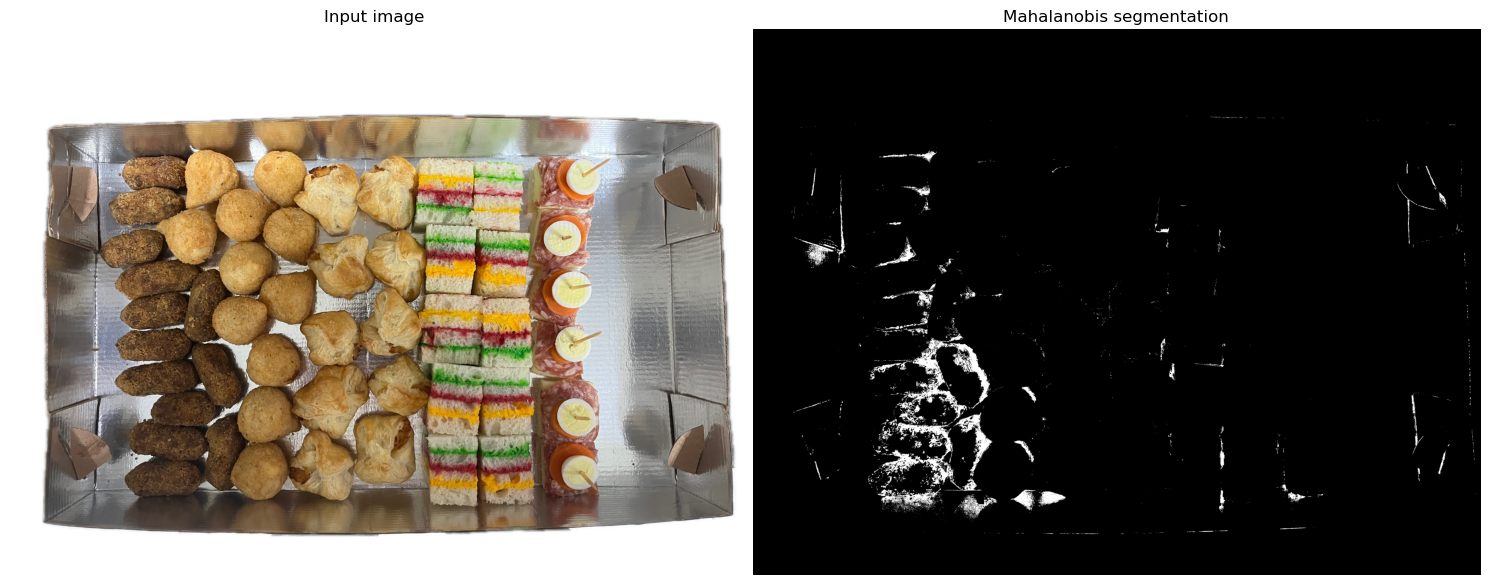

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(3024, 4032), dtype=uint8)

In [ ]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2


def segment_by_mahalanobis(image, target_color, threshold=10.0, sample_neighborhood=15):
    """
    Segment image based on Mahalanobis distance from target HSV color.
    
    Args:
        image: Input image in RGB format
        target_color: Target color as HSV array [H, S, V]
        threshold: Mahalanobis distance threshold (pixels with distance < threshold are segmented)
        sample_neighborhood: Size of neighborhood to sample for covariance calculation
    
    Returns:
        Binary mask where segmented pixels are white (255)
    """
    global PIPELINE_IMG
    
    # Convert to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Reshape HSV image to (N, 3) for processing
    h, w = hsv_image.shape[:2]
    hsv_flat = hsv_image.reshape(-1, 3).astype(np.float32)
    
    # Sample pixels around target color to estimate covariance matrix
    # This helps adapt to the actual color distribution in the image
    mask_sample = np.zeros((h, w), dtype=np.uint8)
    
    # Find pixels close to target color (initial broad range)
    lower_bound = np.array([
        max(0, target_color[0] - sample_neighborhood),
        max(0, target_color[1] - sample_neighborhood),
        max(0, target_color[2] - sample_neighborhood)
    ])
    upper_bound = np.array([
        min(255, target_color[0] + sample_neighborhood),
        min(255, target_color[1] + sample_neighborhood),
        min(255, target_color[2] + sample_neighborhood)
    ])
    
    mask_sample = cv2.inRange(hsv_image, lower_bound, upper_bound)
    sample_pixels = hsv_flat[mask_sample.flatten() > 0]
    
    if len(sample_pixels) < 3:
        # If no samples found, use a default covariance
        cov_matrix = np.eye(3) * 100
        mean_color = target_color.astype(np.float32)
    else:
        mean_color = np.mean(sample_pixels, axis=0)
        cov_matrix = np.cov(sample_pixels.T)
        
        # Ensure covariance matrix is invertible
        if np.linalg.matrix_rank(cov_matrix) < 3:
            cov_matrix += np.eye(3) * 0.1
    
    # Calculate inverse covariance matrix for mahalanobis function
    try:
        inv_cov = np.linalg.inv(cov_matrix)
    except np.linalg.LinAlgError:
        inv_cov = np.linalg.pinv(cov_matrix)
    
    # Calculate Mahalanobis distance for all pixels using scipy function
    distances = np.array([mahalanobis(pixel, mean_color, inv_cov) for pixel in hsv_flat])
    
    # Create binary mask based on threshold
    PIPELINE_IMG = (distances < threshold).astype(np.uint8).reshape(h, w) * 255
    
    show_2_images(image, PIPELINE_IMG, 'Input image', 'Mahalanobis segmentation')
    
    return PIPELINE_IMG


# brown colors HSV:
# [8, 130, 10]
# [10, 56, 127]
# [14, 140, 40]

brown_color = np.array([10, 56, 127])
segment_by_mahalanobis(ORIGINAL_IMG, brown_color, threshold=8.0, sample_neighborhood=20)

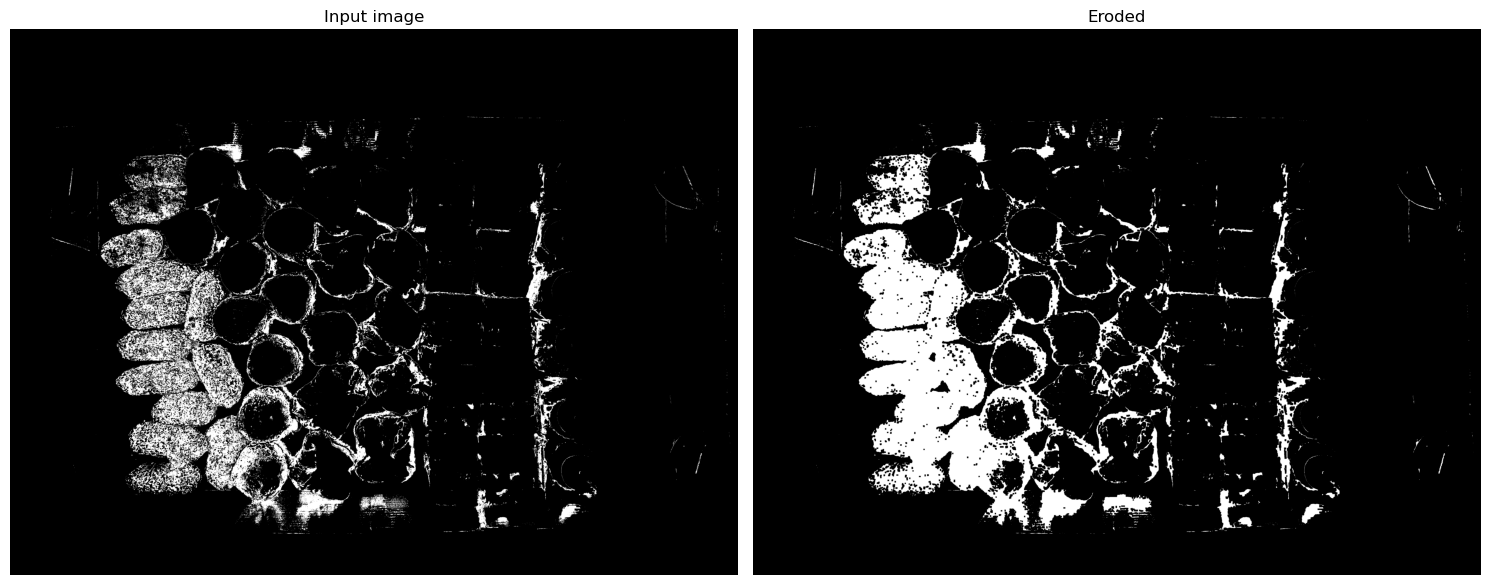

In [12]:
def apply_closing(image, kernel_size, iterations):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    #PIPELINE_IMG = cv2.dilate(gray_image, kernel, iterations=iterations)
    #PIPELINE_IMG = cv2.erode(PIPELINE_IMG, kernel, iterations=iterations)
    PIPELINE_IMG = cv2.morphologyEx(gray_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Eroded')


apply_closing(image=PIPELINE_IMG, kernel_size=(7,7), iterations=1)

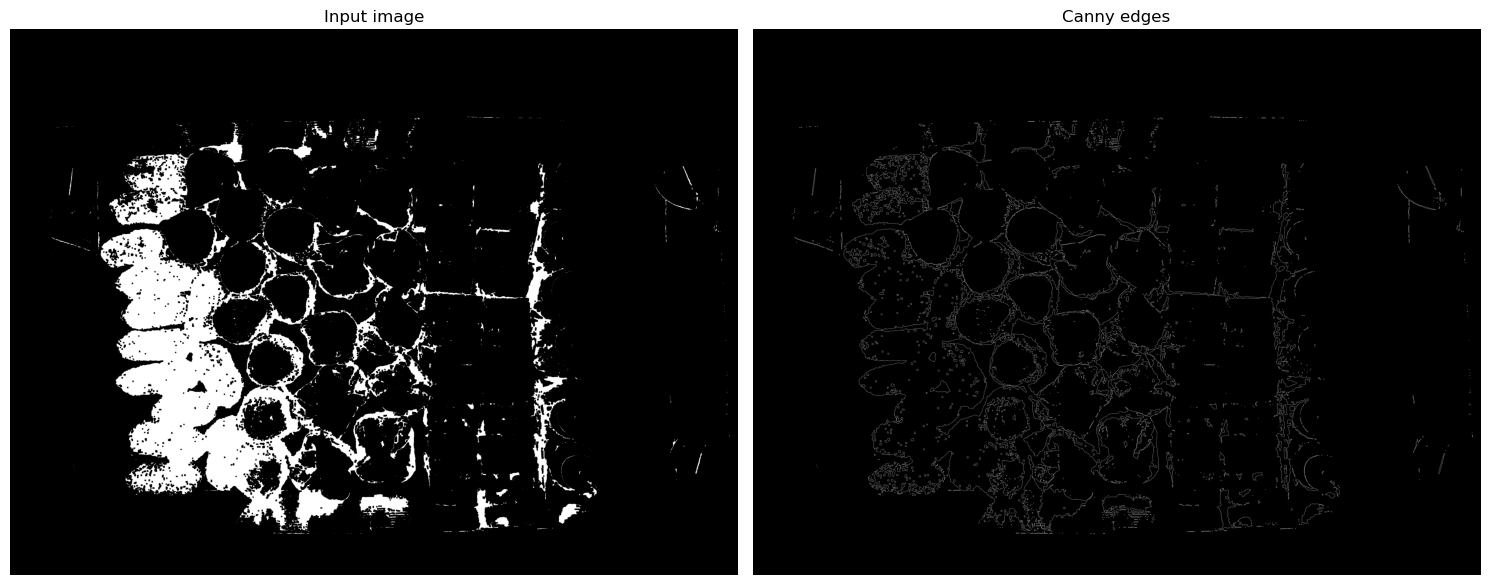

In [13]:
def apply_canny(image, threshold1, threshold2, apertureSize, L2gradient):
    global PIPELINE_IMG

    gray_image = PIPELINE_IMG
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    blurred_image = cv2.bilateralFilter(gray_image, 50, 90, 90)
    #blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    PIPELINE_IMG = cv2.Canny(blurred_image, threshold1=threshold1, threshold2=threshold2, apertureSize=apertureSize, L2gradient=L2gradient) 

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Canny edges')


# NOTE: Original image best with gaussian blurred at 65/195 or bilaterealFilter at 15/45
#apply_canny(image=ORIGINAL_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

apply_canny(image=PIPELINE_IMG, threshold1=15, threshold2=45, apertureSize=3, L2gradient=True)

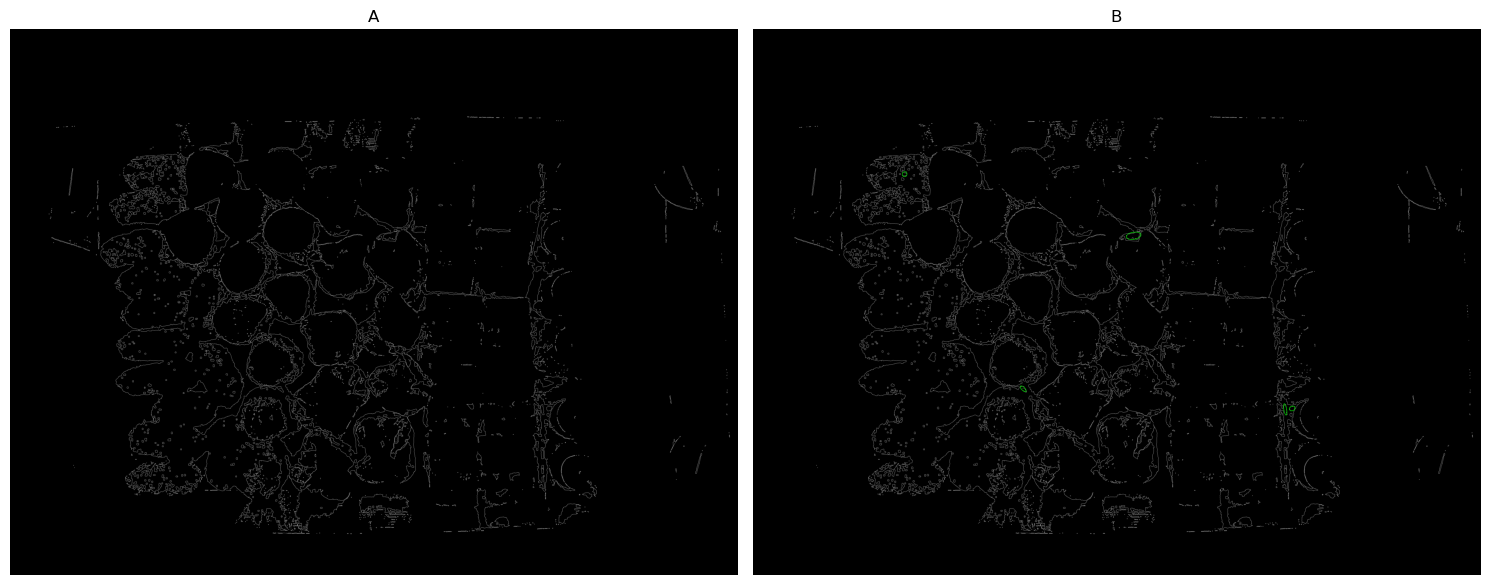

detected: 5


In [14]:
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter


def count_ellipses_hough(image, accuracy=20, threshold=120, min_size=10, max_size=120, top_n=20):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    result = hough_ellipse(image, accuracy=accuracy, threshold=threshold,
                           min_size=min_size, max_size=max_size)
    if result.size == 0:
        return 0, image.copy()

    # result is a structured array; sort by accumulator and take top candidates
    result.sort(order='accumulator')
    best = result[-top_n:]

    count = 0
    for r in best:
        yc, xc, a, b = [int(round(x)) for x in (r['yc'], r['xc'], r['a'], r['b'])]
        orientation = r['orientation']
        if a <= 0 or b <= 0:
            continue
        
        rr, cc = ellipse_perimeter(yc, xc, a, b, orientation)
        # clamp coords and draw
        rr = np.clip(rr, 0, PIPELINE_IMG.shape[0]-1)
        cc = np.clip(cc, 0, PIPELINE_IMG.shape[1]-1)
        PIPELINE_IMG[rr, cc] = (0, 255, 0)
        count += 1

    show_2_images(image, PIPELINE_IMG, 'Input image', 'Hough ellipse')
    return count


def count_ellipses_contours(image, area_min=500, area_ratio_tol=0.9, axis_ratio_max=5.0):
    global PIPELINE_IMG
    if image is None:
        return 0, None

    _, th = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    #mask = np.zeros_like(image)
    
    count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < area_min or len(cnt) < 5:
            continue
        
        ellipse = cv2.fitEllipse(cnt)
        (MA, ma) = ellipse[1]
        a = max(MA, ma) / 2.0
        b = min(MA, ma) / 2.0
        ellipse_area = np.pi * a * b
        if ellipse_area <= 0:
            continue
        
        area_ratio = area / ellipse_area
        axis_ratio = (MA / ma) if ma > 0 else 999
        
        if area_ratio >= area_ratio_tol and axis_ratio <= axis_ratio_max:
            cv2.ellipse(out, ellipse, (0,255,0), 2)
            #cv2.drawContours(mask, [cnt], -1, 255, -1)
            count += 1

    return count, out


# executed for 14min and nothing, too slow!
#count = count_ellipses_hough(PIPELINE_IMG)


count, out = count_ellipses_contours(PIPELINE_IMG)
show_2_images(PIPELINE_IMG, out, 'A', 'B')

print('detected:', count)